<a href="https://colab.research.google.com/github/cubukcum/Cartoon2Real-Image-Conversion/blob/main/Cartoon_to_Real_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Cartoon to Real Images

In [1]:
!pip install natsort

In [2]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-gg_4skzu
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-gg_4skzu
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101055 sha256=3a6fea3bf0a26a57aa432edaacdebe3d2875d50109923d5ae0d7dddee4372e9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-utvsrcnx/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [3]:
from __future__ import print_function, division

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam


from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator


from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import natsort
import scipy
import sys
import os
import cv2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/testSet.zip

Archive:  /content/drive/MyDrive/testSet.zip
   creating: testSet/
  inflating: __MACOSX/._testSet      
  inflating: testSet/s5.jpg          
  inflating: __MACOSX/testSet/._s5.jpg  
  inflating: testSet/s4.jpg          
  inflating: __MACOSX/testSet/._s4.jpg  
  inflating: testSet/s1.jpg          
  inflating: __MACOSX/testSet/._s1.jpg  
  inflating: testSet/s3.jpg          
  inflating: __MACOSX/testSet/._s3.jpg  
  inflating: testSet/s2.jpg          
  inflating: __MACOSX/testSet/._s2.jpg  


In [6]:
!unzip /content/drive/MyDrive/CartoonDataset.zip

Archive:  /content/drive/MyDrive/CartoonDataset.zip
   creating: Cartoon Dataset/
  inflating: __MACOSX/._Cartoon Dataset  
  inflating: Cartoon Dataset/.DS_Store  
  inflating: __MACOSX/Cartoon Dataset/._.DS_Store  
   creating: Cartoon Dataset/Sketches/
  inflating: __MACOSX/Cartoon Dataset/._Sketches  
   creating: Cartoon Dataset/Photos/
  inflating: __MACOSX/Cartoon Dataset/._Photos  
  inflating: Cartoon Dataset/Sketches/f-040-01.jpg  
  inflating: __MACOSX/Cartoon Dataset/Sketches/._f-040-01.jpg  
  inflating: Cartoon Dataset/Sketches/m-012-01.jpg  
  inflating: __MACOSX/Cartoon Dataset/Sketches/._m-012-01.jpg  
  inflating: Cartoon Dataset/Sketches/m-071-01.jpg  
  inflating: __MACOSX/Cartoon Dataset/Sketches/._m-071-01.jpg  
  inflating: Cartoon Dataset/Sketches/f-023-01.jpg  
  inflating: __MACOSX/Cartoon Dataset/Sketches/._f-023-01.jpg  
  inflating: Cartoon Dataset/Sketches/m-100-01.jpg  
  inflating: __MACOSX/Cartoon Dataset/Sketches/._m-100-01.jpg  
  inflating: Cartoon D

<a id="1"></a>
## Dataset Exploration
The dataset consists of two main folders:

1. Photos: This folder contains 188 JPEG photos (200x250 pixels) of real people.
2. Sketches: This folder contains 188 JPEG images (200x250 pixels) drawings of people.

In [7]:

def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

def load_images(list_path, size=(256, 256)):
    img_list = list()
    for filename in list_path:
        pixels = load_img(filename, target_size=size)
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

def load_images(list_path, size=(256, 256), augment=False):
    img_list = []
    datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=False,  # randomly flip images vertically
        zoom_range=0.1,  # randomly zoom image
        shear_range=0.1,  # randomly apply shearing transformation
        fill_mode='nearest'  # filling pixels outside the boundaries
    )

    for filename in list_path:
        pixels = load_img(filename, target_size=size)
        if augment:
            img = img_to_array(pixels)
            img = np.expand_dims(img, axis=0)
            aug_iter = datagen.flow(img, batch_size=1)
            augmented_images = [next(aug_iter)[0].astype(np.uint8) for _ in range(1)]
            pixels = augmented_images[0]

        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)

    return np.asarray(img_list)


In [8]:
# dataset path
b_photo_path = '/content/Cartoon Dataset/Photos/'
b_sketch_path = '/content/Cartoon Dataset/Sketches/'

blue_photo = load_filename(b_photo_path)
blue_sketch = load_filename(b_sketch_path)

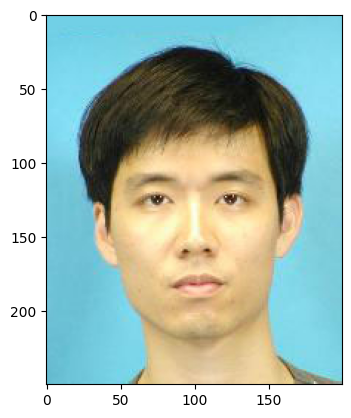

In [9]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_photo[100]).astype('uint8'), cv2.COLOR_BGR2RGB))

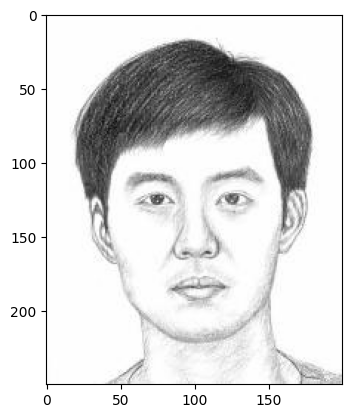

In [10]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_sketch[100]).astype('uint8'), cv2.COLOR_BGR2RGB))

<a id="2"></a>
## Dataset Preprocessing
### Image Conversion and Normalization
* Color Conversion: Cartoonish images were converted from grayscale to RGB to match the format of real images.

* Normalization: Pixel values were scaled to the range [0, 1] to facilitate model training.

### Data Augmentation

Augmentation Techniques: Implemented augmentation techniques such as random flips and rotations to increase dataset variability and robustness.

In [11]:
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset

    ix = np.random.randint(0, trainA.shape[0], n_samples)

    X1, X2 = trainA[ix], trainB[ix]

    y = np.ones((n_samples, patch_shape, patch_shape, 1))

    return [X1, X2], y


def generate_fake_samples(g_model, samples, patch_shape):

    X = g_model.predict(samples)

    y = np.zeros((len(X), patch_shape, patch_shape, 1))

    return X, y

In [12]:
def summarize_performance(step, g_model, d_model, dataset, target_dir='', n_samples=3):
    if target_dir and not os.path.exists(target_dir):
        os.mkdir(target_dir)
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])

    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(target_dir + filename1)
    plt.close()

    g_model.save(target_dir + 'g_model.h5')

    d_model.save(target_dir + 'd_model.h5')

    print('>Saved: %s and %s' % (filename1, 'g_model & d_model'))

<a id="3"></a>
## Model Selection
### Generative Adversarial Network (GAN)
* Architecture: Utilized a GAN framework consisting of a Generator and a Discriminator.
* Loss Function: Adversarial loss combined with pixel-wise loss to enhance image fidelity.
* Training Strategy: Adam optimizer with a learning rate of 0.0002 for both Generator and Discriminator.

## Generator

In [13]:
def generator(img_shape):
    def conv2d(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d

    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu')(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = InstanceNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d

    # Input Layer
    in_img = Input(shape=img_shape)

    # Downsampling
    d1 = conv2d(in_img, 64, norm=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)

    # Upsampling
    u1 = deconv2d(d7, d6, 512)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256, dropout=0)
    u5 = deconv2d(u4, d2, 128, dropout=0)
    u6 = deconv2d(u5, d1, 64, dropout=0)
    u7 = UpSampling2D(size=2)(u6)

    out_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

    return Model(in_img, out_img, name='generator')

## Discriminator

In [14]:
def discriminator(img_shape):
    def d_layer(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d

    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)

    merged = Concatenate()([in_src_img, in_target_img])

    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d1, 256)
    d4 = d_layer(d1, 512)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([in_src_img, in_target_img], out, name='discriminator')

## GAN

In [15]:
def GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='GAN')
    return model

## Train GAN model

In [16]:
def train(d_model, g_model, gan_model, data, target_dir, n_epochs=100, n_batch=16,augment=False):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]

    blue_photo = data[0]
    blue_sketch = data[1]

    for i in range(n_epochs):
        print(' ========== Epoch', i+1, '========== ')

        blue_photo, blue_sketch = shuffle(blue_photo, blue_sketch)

        for j in range(int(len(blue_photo)/n_batch)):

            start = int(j*n_batch)
            end = int(min(len(blue_photo), (j*n_batch)+n_batch))

            if augment:
                dataset = [
                    load_images(blue_photo[start:end], augment=True),
                    load_images(blue_sketch[start:end], augment=True)
                ]
            else:
                dataset = [
                    load_images(blue_photo[start:end]),
                    load_images(blue_sketch[start:end])
                ]

            #dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]

            # select a batch of real samples
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

            # generate a batch of fake samples
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

            # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

            d_loss = 0.5 * np.add(d_loss1, d_loss2)

            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

            # summarize performance
            print('Batch : %d, D Loss : %.3f | G Loss : %.3f' % (j+1, d_loss, g_loss))

        # summarize model performance
        if (i+1) % 2 == 0:
          summarize_performance(i, g_model, d_model, dataset, target_dir)

## Loss Function

In [17]:
import tensorflow as tf
import keras.backend as K
from keras.losses import mean_absolute_error

def pixel_loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def contextual_loss (y_true, y_pred):
    a = tf.image.rgb_to_grayscale(tf.slice(
                                y_pred,
                                [0,0,0,0],
                                [16, 256, 256, 3]))

    b = tf.image.rgb_to_grayscale(tf.slice(
                                y_true,
                                [0,0,0,0],
                                [16, 256, 256, 3]))

    y_pred = tf.divide(tf.add(tf.reshape(a, [tf.shape(a)[0], -1]), 1), 2)
    y_true = tf.divide(tf.add(tf.reshape(b, [tf.shape(b)[0], -1]), 1), 2)

#     tf.assert_rank(y_true,2)
#     tf.assert_rank(y_pred,2)

    p_shape = tf.shape(y_true)
    q_shape = tf.shape(y_pred)
#     tf.assert_equal(p_shape, q_shape)

    # normalize sum to 1
    p_ = tf.divide(y_true, tf.tile(tf.expand_dims(tf.reduce_sum(y_true, axis=1), 1), [1,p_shape[1]]))
    q_ = tf.divide(y_pred, tf.tile(tf.expand_dims(tf.reduce_sum(y_pred, axis=1), 1), [1,p_shape[1]]))

    return tf.reduce_sum(tf.multiply(p_, tf.math.log(tf.divide(p_, q_))), axis=1)

def total_loss (y_true, y_pred):

    px_loss = pixel_loss(y_true, y_pred)

    ctx_loss = contextual_loss(y_true, y_pred)

    return (0.2 * px_loss) + (0.8 * ctx_loss)

## Load Dataset

## Define GAN Model

In [18]:
img_shape = (256, 256, 3)

d_model = discriminator(img_shape)

g_model = generator(img_shape)

gan_model = GAN(g_model, d_model, img_shape)

In [19]:
gan_model.summary()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 generator (Functional)      (None, 256, 256, 3)          4182569   ['input_4[0][0]']             
                                                          1                                       
                                                                                                  
 discriminator (Functional)  (None, 64, 64, 1)            539203    ['input_4[0][0]',             
                                                                     'generator[0][0]']           
                                                                                                

In [20]:
opt = Adam(learning_rate=2e-4, beta_1=0.5)

d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])

<a id="4"></a>
## Training Process
### Training Details
* Epochs: Trained over 50 epochs to ensure convergence and stability.
Batch Size: Used a batch size of 16 to balance memory constraints and training efficiency.
* Metrics: Monitored generator and discriminator losses, generator accuracy, and ROC curves to evaluate model performance.
Evaluation Criteria
* Visual Inspection: Subjective evaluation of generated images compared to ground truth real images.
Quantitative Metrics: Calculated ROC curves to assess the discriminator's ability to distinguish between generated and real images.

## Start Training

In [21]:
train(d_model, g_model, gan_model, [blue_sketch, blue_photo], '/content/', n_epochs =50, n_batch=16,augment=True)

 ========== Epoch 1 ========== 
1/1 [==============================] - 9s 9s/step
Batch : 1, D Loss : 3.027 | G Loss : 40.724
1/1 [==============================] - 0s 32ms/step
Batch : 2, D Loss : 2.924 | G Loss : 17.943
1/1 [==============================] - 0s 32ms/step
Batch : 3, D Loss : 3.012 | G Loss : 19.474
1/1 [==============================] - 0s 41ms/step
Batch : 4, D Loss : 2.580 | G Loss : 21.292
1/1 [==============================] - 0s 31ms/step
Batch : 5, D Loss : 3.017 | G Loss : 17.392
1/1 [==============================] - 0s 31ms/step
Batch : 6, D Loss : 3.042 | G Loss : 15.259
1/1 [==============================] - 0s 31ms/step
Batch : 7, D Loss : 3.124 | G Loss : 18.762
1/1 [==============================] - 0s 31ms/step
Batch : 8, D Loss : 3.110 | G Loss : 16.623
1/1 [==============================] - 0s 26ms/step
Batch : 9, D Loss : 2.983 | G Loss : 16.922
1/1 [==============================] - 0s 31ms/step
Batch : 10, D Loss : 3.368 | G Loss : 18.478
1/1 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: plot_000002.png and g_model & d_model
 ========== Epoch 3 ========== 
1/1 [==============================] - 0s 26ms/step
Batch : 1, D Loss : 3.350 | G Loss : 15.753
1/1 [==============================] - 0s 28ms/step
Batch : 2, D Loss : 3.204 | G Loss : 17.233
1/1 [==============================] - 0s 26ms/step
Batch : 3, D Loss : 3.309 | G Loss : 14.964
1/1 [==============================] - 0s 27ms/step
Batch : 4, D Loss : 3.309 | G Loss : 12.932
1/1 [==============================] - 0s 27ms/step
Batch : 5, D Loss : 3.159 | G Loss : 12.309
1/1 [==============================] - 0s 41ms/step
Batch : 6, D Loss : 3.528 | G Loss : 13.313
1/1 [==============================] - 0s 44ms/step
Batch : 7, D Loss : 3.384 | G Loss : 14.516
1/1 [==============================] - 0s 27ms/step
Batch : 8, D Loss : 3.524 | G Loss : 13.902
1/1 [==============================] - 0s 30ms/step
Batch : 9, D Loss : 3.508 | G Loss : 13.501
1/1 [==============================] - 0s 27ms/step
Batch 

>Saved: plot_000004.png and g_model & d_model
 ========== Epoch 5 ========== 
1/1 [==============================] - 0s 26ms/step
Batch : 1, D Loss : 3.479 | G Loss : 12.487
1/1 [==============================] - 0s 41ms/step
Batch : 2, D Loss : 3.338 | G Loss : 12.884
1/1 [==============================] - 0s 26ms/step
Batch : 3, D Loss : 3.083 | G Loss : 15.839
1/1 [==============================] - 0s 28ms/step
Batch : 4, D Loss : 3.280 | G Loss : 11.017
1/1 [==============================] - 0s 28ms/step
Batch : 5, D Loss : 3.365 | G Loss : 14.692
1/1 [==============================] - 0s 28ms/step
Batch : 6, D Loss : 3.466 | G Loss : 10.779
1/1 [==============================] - 0s 27ms/step
Batch : 7, D Loss : 3.473 | G Loss : 13.865
1/1 [==============================] - 0s 29ms/step
Batch : 8, D Loss : 3.278 | G Loss : 15.618
1/1 [==============================] - 0s 42ms/step
Batch : 9, D Loss : 3.471 | G Loss : 13.822
1/1 [==============================] - 0s 28ms/step
Batch 

>Saved: plot_000006.png and g_model & d_model
 ========== Epoch 7 ========== 
1/1 [==============================] - 0s 28ms/step
Batch : 1, D Loss : 3.416 | G Loss : 12.443
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 3.229 | G Loss : 14.826
1/1 [==============================] - 0s 28ms/step
Batch : 3, D Loss : 3.340 | G Loss : 11.557
1/1 [==============================] - 0s 28ms/step
Batch : 4, D Loss : 3.416 | G Loss : 14.519
1/1 [==============================] - 0s 29ms/step
Batch : 5, D Loss : 3.279 | G Loss : 12.126
1/1 [==============================] - 0s 26ms/step
Batch : 6, D Loss : 3.490 | G Loss : 14.244
1/1 [==============================] - 0s 40ms/step
Batch : 7, D Loss : 3.491 | G Loss : 13.810
1/1 [==============================] - 0s 28ms/step
Batch : 8, D Loss : 3.516 | G Loss : 14.086
1/1 [==============================] - 0s 26ms/step
Batch : 9, D Loss : 3.581 | G Loss : 14.176
1/1 [==============================] - 0s 26ms/step
Batch 

>Saved: plot_000008.png and g_model & d_model
 ========== Epoch 9 ========== 
1/1 [==============================] - 0s 30ms/step
Batch : 1, D Loss : 3.486 | G Loss : 12.432
1/1 [==============================] - 0s 37ms/step
Batch : 2, D Loss : 3.315 | G Loss : 12.432
1/1 [==============================] - 0s 39ms/step
Batch : 3, D Loss : 3.216 | G Loss : 12.342
1/1 [==============================] - 0s 28ms/step
Batch : 4, D Loss : 3.440 | G Loss : 12.488
1/1 [==============================] - 0s 26ms/step
Batch : 5, D Loss : 3.540 | G Loss : 13.038
1/1 [==============================] - 0s 26ms/step
Batch : 6, D Loss : 3.458 | G Loss : 11.402
1/1 [==============================] - 0s 27ms/step
Batch : 7, D Loss : 3.344 | G Loss : 11.417
1/1 [==============================] - 0s 26ms/step
Batch : 8, D Loss : 3.453 | G Loss : 13.091
1/1 [==============================] - 0s 37ms/step
Batch : 9, D Loss : 3.465 | G Loss : 13.049
1/1 [==============================] - 0s 27ms/step
Batch 

>Saved: plot_000010.png and g_model & d_model
 ========== Epoch 11 ========== 
1/1 [==============================] - 0s 26ms/step
Batch : 1, D Loss : 3.225 | G Loss : 12.130
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 3.289 | G Loss : 11.882
1/1 [==============================] - 0s 27ms/step
Batch : 3, D Loss : 3.250 | G Loss : 15.783
1/1 [==============================] - 0s 26ms/step
Batch : 4, D Loss : 3.429 | G Loss : 11.886
1/1 [==============================] - 0s 41ms/step
Batch : 5, D Loss : 3.518 | G Loss : 12.448
1/1 [==============================] - 0s 31ms/step
Batch : 6, D Loss : 3.420 | G Loss : 12.771
1/1 [==============================] - 0s 27ms/step
Batch : 7, D Loss : 3.569 | G Loss : 11.645
1/1 [==============================] - 0s 26ms/step
Batch : 8, D Loss : 3.419 | G Loss : 10.863
1/1 [==============================] - 0s 34ms/step
Batch : 9, D Loss : 3.366 | G Loss : 12.152
1/1 [==============================] - 0s 26ms/step
Batch

>Saved: plot_000012.png and g_model & d_model
 ========== Epoch 13 ========== 
1/1 [==============================] - 0s 28ms/step
Batch : 1, D Loss : 3.298 | G Loss : 9.651
1/1 [==============================] - 0s 28ms/step
Batch : 2, D Loss : 3.305 | G Loss : 11.286
1/1 [==============================] - 0s 53ms/step
Batch : 3, D Loss : 3.472 | G Loss : 12.301
1/1 [==============================] - 0s 29ms/step
Batch : 4, D Loss : 3.504 | G Loss : 12.485
1/1 [==============================] - 0s 26ms/step
Batch : 5, D Loss : 3.500 | G Loss : 12.063
1/1 [==============================] - 0s 36ms/step
Batch : 6, D Loss : 3.471 | G Loss : 11.536
1/1 [==============================] - 0s 26ms/step
Batch : 7, D Loss : 3.284 | G Loss : 13.608
1/1 [==============================] - 0s 27ms/step
Batch : 8, D Loss : 3.312 | G Loss : 13.099
1/1 [==============================] - 0s 26ms/step
Batch : 9, D Loss : 3.511 | G Loss : 10.630
1/1 [==============================] - 0s 26ms/step
Batch 

>Saved: plot_000014.png and g_model & d_model
 ========== Epoch 15 ========== 
1/1 [==============================] - 0s 26ms/step
Batch : 1, D Loss : 3.421 | G Loss : 12.235
1/1 [==============================] - 0s 26ms/step
Batch : 2, D Loss : 3.458 | G Loss : 14.780
1/1 [==============================] - 0s 38ms/step
Batch : 3, D Loss : 3.554 | G Loss : 11.321
1/1 [==============================] - 0s 38ms/step
Batch : 4, D Loss : 3.537 | G Loss : 12.620
1/1 [==============================] - 0s 26ms/step
Batch : 5, D Loss : 3.608 | G Loss : 12.434
1/1 [==============================] - 0s 29ms/step
Batch : 6, D Loss : 3.463 | G Loss : 13.208
1/1 [==============================] - 0s 27ms/step
Batch : 7, D Loss : 3.376 | G Loss : 12.394
1/1 [==============================] - 0s 28ms/step
Batch : 8, D Loss : 3.423 | G Loss : 12.479
1/1 [==============================] - 0s 26ms/step
Batch : 9, D Loss : 3.412 | G Loss : 12.019
1/1 [==============================] - 0s 26ms/step
Batch

>Saved: plot_000016.png and g_model & d_model
 ========== Epoch 17 ========== 
1/1 [==============================] - 0s 27ms/step
Batch : 1, D Loss : 3.493 | G Loss : 11.754
1/1 [==============================] - 0s 26ms/step
Batch : 2, D Loss : 3.384 | G Loss : 10.761
1/1 [==============================] - 0s 27ms/step
Batch : 3, D Loss : 3.484 | G Loss : 12.014
1/1 [==============================] - 0s 26ms/step
Batch : 4, D Loss : 3.451 | G Loss : 12.212
1/1 [==============================] - 0s 26ms/step
Batch : 5, D Loss : 3.409 | G Loss : 14.248
1/1 [==============================] - 0s 28ms/step
Batch : 6, D Loss : 3.371 | G Loss : 11.239
1/1 [==============================] - 0s 41ms/step
Batch : 7, D Loss : 3.457 | G Loss : 13.694
1/1 [==============================] - 0s 28ms/step
Batch : 8, D Loss : 3.337 | G Loss : 12.552
1/1 [==============================] - 0s 26ms/step
Batch : 9, D Loss : 3.558 | G Loss : 11.794
1/1 [==============================] - 0s 26ms/step
Batch

>Saved: plot_000018.png and g_model & d_model
 ========== Epoch 19 ========== 
1/1 [==============================] - 0s 26ms/step
Batch : 1, D Loss : 3.484 | G Loss : 11.521
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 3.326 | G Loss : 12.196
1/1 [==============================] - 0s 44ms/step
Batch : 3, D Loss : 3.433 | G Loss : 11.341
1/1 [==============================] - 0s 48ms/step
Batch : 4, D Loss : 3.536 | G Loss : 12.892
1/1 [==============================] - 0s 26ms/step
Batch : 5, D Loss : 3.490 | G Loss : 13.370
1/1 [==============================] - 0s 31ms/step
Batch : 6, D Loss : 3.420 | G Loss : 12.860
1/1 [==============================] - 0s 27ms/step
Batch : 7, D Loss : 3.351 | G Loss : 11.204
1/1 [==============================] - 0s 27ms/step
Batch : 8, D Loss : 3.461 | G Loss : 10.477
1/1 [==============================] - 0s 27ms/step
Batch : 9, D Loss : 3.379 | G Loss : 13.886
1/1 [==============================] - 0s 32ms/step
Batch

>Saved: plot_000020.png and g_model & d_model
 ========== Epoch 21 ========== 
1/1 [==============================] - 0s 28ms/step
Batch : 1, D Loss : 3.489 | G Loss : 12.466
1/1 [==============================] - 0s 28ms/step
Batch : 2, D Loss : 3.573 | G Loss : 11.612
1/1 [==============================] - 0s 27ms/step
Batch : 3, D Loss : 3.445 | G Loss : 11.425
1/1 [==============================] - 0s 26ms/step
Batch : 4, D Loss : 3.440 | G Loss : 9.778
1/1 [==============================] - 0s 26ms/step
Batch : 5, D Loss : 3.472 | G Loss : 12.810
1/1 [==============================] - 0s 39ms/step
Batch : 6, D Loss : 3.404 | G Loss : 10.810
1/1 [==============================] - 0s 38ms/step
Batch : 7, D Loss : 3.358 | G Loss : 10.803
1/1 [==============================] - 0s 27ms/step
Batch : 8, D Loss : 3.465 | G Loss : 12.018
1/1 [==============================] - 0s 26ms/step
Batch : 9, D Loss : 3.545 | G Loss : 11.011
1/1 [==============================] - 0s 28ms/step
Batch 

>Saved: plot_000022.png and g_model & d_model
 ========== Epoch 23 ========== 
1/1 [==============================] - 0s 38ms/step
Batch : 1, D Loss : 3.514 | G Loss : 12.466
1/1 [==============================] - 0s 38ms/step
Batch : 2, D Loss : 3.266 | G Loss : 12.080
1/1 [==============================] - 0s 29ms/step
Batch : 3, D Loss : 3.414 | G Loss : 12.951
1/1 [==============================] - 0s 28ms/step
Batch : 4, D Loss : 3.372 | G Loss : 10.534
1/1 [==============================] - 0s 32ms/step
Batch : 5, D Loss : 3.468 | G Loss : 13.134
1/1 [==============================] - 0s 27ms/step
Batch : 6, D Loss : 3.617 | G Loss : 11.950
1/1 [==============================] - 0s 33ms/step
Batch : 7, D Loss : 3.541 | G Loss : 12.215
1/1 [==============================] - 0s 35ms/step
Batch : 8, D Loss : 3.283 | G Loss : 13.186
1/1 [==============================] - 0s 27ms/step
Batch : 9, D Loss : 3.376 | G Loss : 11.711
1/1 [==============================] - 0s 27ms/step
Batch

>Saved: plot_000024.png and g_model & d_model
 ========== Epoch 25 ========== 
1/1 [==============================] - 0s 27ms/step
Batch : 1, D Loss : 3.467 | G Loss : 11.676
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 3.386 | G Loss : 13.627
1/1 [==============================] - 0s 29ms/step
Batch : 3, D Loss : 3.362 | G Loss : 12.195
1/1 [==============================] - 0s 28ms/step
Batch : 4, D Loss : 3.457 | G Loss : 12.104
1/1 [==============================] - 0s 28ms/step
Batch : 5, D Loss : 3.504 | G Loss : 13.013
1/1 [==============================] - 0s 26ms/step
Batch : 6, D Loss : 3.431 | G Loss : 11.008
1/1 [==============================] - 0s 35ms/step
Batch : 7, D Loss : 3.421 | G Loss : 10.062
1/1 [==============================] - 0s 29ms/step
Batch : 8, D Loss : 3.365 | G Loss : 12.290
1/1 [==============================] - 0s 27ms/step
Batch : 9, D Loss : 3.545 | G Loss : 11.713
1/1 [==============================] - 0s 27ms/step
Batch

>Saved: plot_000026.png and g_model & d_model
 ========== Epoch 27 ========== 
1/1 [==============================] - 0s 28ms/step
Batch : 1, D Loss : 3.596 | G Loss : 12.244
1/1 [==============================] - 0s 28ms/step
Batch : 2, D Loss : 3.626 | G Loss : 11.477
1/1 [==============================] - 0s 26ms/step
Batch : 3, D Loss : 3.476 | G Loss : 12.110
1/1 [==============================] - 0s 32ms/step
Batch : 4, D Loss : 3.392 | G Loss : 11.152
1/1 [==============================] - 0s 26ms/step
Batch : 5, D Loss : 3.457 | G Loss : 14.022
1/1 [==============================] - 0s 39ms/step
Batch : 6, D Loss : 3.588 | G Loss : 13.039
1/1 [==============================] - 0s 42ms/step
Batch : 7, D Loss : 3.593 | G Loss : 14.065
1/1 [==============================] - 0s 26ms/step
Batch : 8, D Loss : 3.478 | G Loss : 10.556
1/1 [==============================] - 0s 27ms/step
Batch : 9, D Loss : 3.410 | G Loss : 13.133
1/1 [==============================] - 0s 29ms/step
Batch

>Saved: plot_000028.png and g_model & d_model
 ========== Epoch 29 ========== 
1/1 [==============================] - 0s 27ms/step
Batch : 1, D Loss : 3.500 | G Loss : 12.978
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 3.553 | G Loss : 11.110
1/1 [==============================] - 0s 26ms/step
Batch : 3, D Loss : 3.587 | G Loss : 11.876
1/1 [==============================] - 0s 27ms/step
Batch : 4, D Loss : 3.474 | G Loss : 10.145
1/1 [==============================] - 0s 26ms/step
Batch : 5, D Loss : 3.435 | G Loss : 10.804
1/1 [==============================] - 0s 34ms/step
Batch : 6, D Loss : 3.409 | G Loss : 15.320
1/1 [==============================] - 0s 35ms/step
Batch : 7, D Loss : 3.427 | G Loss : 11.443
1/1 [==============================] - 0s 26ms/step
Batch : 8, D Loss : 3.360 | G Loss : 11.393
1/1 [==============================] - 0s 26ms/step
Batch : 9, D Loss : 3.522 | G Loss : 10.656
1/1 [==============================] - 0s 26ms/step
Batch

>Saved: plot_000030.png and g_model & d_model
 ========== Epoch 31 ========== 
1/1 [==============================] - 0s 47ms/step
Batch : 1, D Loss : 3.412 | G Loss : 11.983
1/1 [==============================] - 0s 37ms/step
Batch : 2, D Loss : 3.443 | G Loss : 11.162
1/1 [==============================] - 0s 33ms/step
Batch : 3, D Loss : 3.304 | G Loss : 12.342
1/1 [==============================] - 0s 27ms/step
Batch : 4, D Loss : 3.525 | G Loss : 11.723
1/1 [==============================] - 0s 26ms/step
Batch : 5, D Loss : 3.664 | G Loss : 11.977
1/1 [==============================] - 0s 27ms/step
Batch : 6, D Loss : 3.536 | G Loss : 13.042
1/1 [==============================] - 0s 26ms/step
Batch : 7, D Loss : 3.491 | G Loss : 11.740
1/1 [==============================] - 0s 28ms/step
Batch : 8, D Loss : 3.328 | G Loss : 12.080
1/1 [==============================] - 0s 35ms/step
Batch : 9, D Loss : 3.359 | G Loss : 10.666
1/1 [==============================] - 0s 28ms/step
Batch

>Saved: plot_000032.png and g_model & d_model
 ========== Epoch 33 ========== 
1/1 [==============================] - 0s 26ms/step
Batch : 1, D Loss : 3.420 | G Loss : 10.376
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 3.509 | G Loss : 12.702
1/1 [==============================] - 0s 27ms/step
Batch : 3, D Loss : 3.516 | G Loss : 10.999
1/1 [==============================] - 0s 26ms/step
Batch : 4, D Loss : 3.445 | G Loss : 11.999
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 3.550 | G Loss : 13.855
1/1 [==============================] - 0s 27ms/step
Batch : 6, D Loss : 3.504 | G Loss : 11.569
1/1 [==============================] - 0s 37ms/step
Batch : 7, D Loss : 3.396 | G Loss : 12.950
1/1 [==============================] - 0s 28ms/step
Batch : 8, D Loss : 3.382 | G Loss : 13.145
1/1 [==============================] - 0s 26ms/step
Batch : 9, D Loss : 3.327 | G Loss : 12.655
1/1 [==============================] - 0s 26ms/step
Batch

>Saved: plot_000034.png and g_model & d_model
 ========== Epoch 35 ========== 
1/1 [==============================] - 0s 29ms/step
Batch : 1, D Loss : 3.457 | G Loss : 11.617
1/1 [==============================] - 0s 42ms/step
Batch : 2, D Loss : 3.531 | G Loss : 12.207
1/1 [==============================] - 0s 27ms/step
Batch : 3, D Loss : 3.447 | G Loss : 12.294
1/1 [==============================] - 0s 26ms/step
Batch : 4, D Loss : 3.306 | G Loss : 11.720
1/1 [==============================] - 0s 30ms/step
Batch : 5, D Loss : 3.463 | G Loss : 13.633
1/1 [==============================] - 0s 26ms/step
Batch : 6, D Loss : 3.482 | G Loss : 11.741
1/1 [==============================] - 0s 26ms/step
Batch : 7, D Loss : 3.480 | G Loss : 12.591
1/1 [==============================] - 0s 26ms/step
Batch : 8, D Loss : 3.456 | G Loss : 12.970
1/1 [==============================] - 0s 40ms/step
Batch : 9, D Loss : 3.478 | G Loss : 11.417
1/1 [==============================] - 0s 26ms/step
Batch

>Saved: plot_000036.png and g_model & d_model
 ========== Epoch 37 ========== 
1/1 [==============================] - 0s 27ms/step
Batch : 1, D Loss : 3.484 | G Loss : 14.888
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 3.299 | G Loss : 11.281
1/1 [==============================] - 0s 27ms/step
Batch : 3, D Loss : 3.347 | G Loss : 10.849
1/1 [==============================] - 0s 27ms/step
Batch : 4, D Loss : 3.426 | G Loss : 11.392
1/1 [==============================] - 0s 27ms/step
Batch : 5, D Loss : 3.444 | G Loss : 14.585
1/1 [==============================] - 0s 28ms/step
Batch : 6, D Loss : 3.486 | G Loss : 12.336
1/1 [==============================] - 0s 56ms/step
Batch : 7, D Loss : 3.449 | G Loss : 12.507
1/1 [==============================] - 0s 32ms/step
Batch : 8, D Loss : 3.391 | G Loss : 12.544
1/1 [==============================] - 0s 26ms/step
Batch : 9, D Loss : 3.442 | G Loss : 12.335
1/1 [==============================] - 0s 26ms/step
Batch

>Saved: plot_000038.png and g_model & d_model
 ========== Epoch 39 ========== 
1/1 [==============================] - 0s 41ms/step
Batch : 1, D Loss : 3.452 | G Loss : 11.224
1/1 [==============================] - 0s 45ms/step
Batch : 2, D Loss : 3.421 | G Loss : 11.761
1/1 [==============================] - 0s 26ms/step
Batch : 3, D Loss : 3.581 | G Loss : 14.966
1/1 [==============================] - 0s 27ms/step
Batch : 4, D Loss : 3.459 | G Loss : 11.261
1/1 [==============================] - 0s 27ms/step
Batch : 5, D Loss : 3.466 | G Loss : 12.552
1/1 [==============================] - 0s 27ms/step
Batch : 6, D Loss : 3.463 | G Loss : 11.437
1/1 [==============================] - 0s 26ms/step
Batch : 7, D Loss : 3.446 | G Loss : 12.191
1/1 [==============================] - 0s 28ms/step
Batch : 8, D Loss : 3.388 | G Loss : 12.670
1/1 [==============================] - 0s 43ms/step
Batch : 9, D Loss : 3.447 | G Loss : 12.680
1/1 [==============================] - 0s 27ms/step
Batch

>Saved: plot_000040.png and g_model & d_model
 ========== Epoch 41 ========== 
1/1 [==============================] - 0s 27ms/step
Batch : 1, D Loss : 3.447 | G Loss : 9.144
1/1 [==============================] - 0s 26ms/step
Batch : 2, D Loss : 3.514 | G Loss : 9.628
1/1 [==============================] - 0s 36ms/step
Batch : 3, D Loss : 3.459 | G Loss : 13.568
1/1 [==============================] - 0s 27ms/step
Batch : 4, D Loss : 3.430 | G Loss : 11.281
1/1 [==============================] - 0s 27ms/step
Batch : 5, D Loss : 3.382 | G Loss : 14.269
1/1 [==============================] - 0s 27ms/step
Batch : 6, D Loss : 3.614 | G Loss : 12.913
1/1 [==============================] - 0s 27ms/step
Batch : 7, D Loss : 3.497 | G Loss : 12.125
1/1 [==============================] - 0s 28ms/step
Batch : 8, D Loss : 3.418 | G Loss : 11.886
1/1 [==============================] - 0s 27ms/step
Batch : 9, D Loss : 3.502 | G Loss : 11.730
1/1 [==============================] - 0s 44ms/step
Batch :

>Saved: plot_000042.png and g_model & d_model
 ========== Epoch 43 ========== 
1/1 [==============================] - 0s 31ms/step
Batch : 1, D Loss : 3.444 | G Loss : 11.832
1/1 [==============================] - 0s 28ms/step
Batch : 2, D Loss : 3.474 | G Loss : 12.080
1/1 [==============================] - 0s 27ms/step
Batch : 3, D Loss : 3.513 | G Loss : 12.946
1/1 [==============================] - 0s 27ms/step
Batch : 4, D Loss : 3.530 | G Loss : 10.933
1/1 [==============================] - 0s 28ms/step
Batch : 5, D Loss : 3.496 | G Loss : 11.897
1/1 [==============================] - 0s 28ms/step
Batch : 6, D Loss : 3.435 | G Loss : 12.717
1/1 [==============================] - 0s 43ms/step
Batch : 7, D Loss : 3.548 | G Loss : 12.473
1/1 [==============================] - 0s 28ms/step
Batch : 8, D Loss : 3.493 | G Loss : 12.624
1/1 [==============================] - 0s 27ms/step
Batch : 9, D Loss : 3.467 | G Loss : 12.138
1/1 [==============================] - 0s 27ms/step
Batch

>Saved: plot_000044.png and g_model & d_model
 ========== Epoch 45 ========== 
1/1 [==============================] - 0s 27ms/step
Batch : 1, D Loss : 3.440 | G Loss : 10.984
1/1 [==============================] - 0s 27ms/step
Batch : 2, D Loss : 3.258 | G Loss : 10.500
1/1 [==============================] - 0s 26ms/step
Batch : 3, D Loss : 3.300 | G Loss : 13.367
1/1 [==============================] - 0s 35ms/step
Batch : 4, D Loss : 3.442 | G Loss : 13.583
1/1 [==============================] - 0s 27ms/step
Batch : 5, D Loss : 3.540 | G Loss : 13.520
1/1 [==============================] - 0s 26ms/step
Batch : 6, D Loss : 3.457 | G Loss : 12.133
1/1 [==============================] - 0s 52ms/step
Batch : 7, D Loss : 3.603 | G Loss : 14.209
1/1 [==============================] - 0s 26ms/step
Batch : 8, D Loss : 3.429 | G Loss : 10.587
1/1 [==============================] - 0s 28ms/step
Batch : 9, D Loss : 3.427 | G Loss : 10.629
1/1 [==============================] - 0s 26ms/step
Batch

>Saved: plot_000046.png and g_model & d_model
 ========== Epoch 47 ========== 
1/1 [==============================] - 0s 27ms/step
Batch : 1, D Loss : 3.385 | G Loss : 11.289
1/1 [==============================] - 0s 48ms/step
Batch : 2, D Loss : 3.399 | G Loss : 10.802
1/1 [==============================] - 0s 47ms/step
Batch : 3, D Loss : 3.512 | G Loss : 11.494
1/1 [==============================] - 0s 40ms/step
Batch : 4, D Loss : 3.445 | G Loss : 12.992
1/1 [==============================] - 0s 27ms/step
Batch : 5, D Loss : 3.505 | G Loss : 11.298
1/1 [==============================] - 0s 28ms/step
Batch : 6, D Loss : 3.359 | G Loss : 10.516
1/1 [==============================] - 0s 29ms/step
Batch : 7, D Loss : 3.412 | G Loss : 10.032
1/1 [==============================] - 0s 26ms/step
Batch : 8, D Loss : 3.358 | G Loss : 14.977
1/1 [==============================] - 0s 37ms/step
Batch : 9, D Loss : 3.522 | G Loss : 12.117
1/1 [==============================] - 0s 37ms/step
Batch

>Saved: plot_000048.png and g_model & d_model
 ========== Epoch 49 ========== 
1/1 [==============================] - 0s 39ms/step
Batch : 1, D Loss : 3.401 | G Loss : 12.498
1/1 [==============================] - 0s 26ms/step
Batch : 2, D Loss : 3.503 | G Loss : 14.240
1/1 [==============================] - 0s 28ms/step
Batch : 3, D Loss : 3.470 | G Loss : 10.350
1/1 [==============================] - 0s 28ms/step
Batch : 4, D Loss : 3.497 | G Loss : 10.841
1/1 [==============================] - 0s 26ms/step
Batch : 5, D Loss : 3.518 | G Loss : 9.788
1/1 [==============================] - 0s 30ms/step
Batch : 6, D Loss : 3.477 | G Loss : 11.190
1/1 [==============================] - 0s 45ms/step
Batch : 7, D Loss : 3.502 | G Loss : 10.850
1/1 [==============================] - 0s 28ms/step
Batch : 8, D Loss : 3.506 | G Loss : 9.582
1/1 [==============================] - 0s 34ms/step
Batch : 9, D Loss : 3.515 | G Loss : 11.839
1/1 [==============================] - 0s 31ms/step
Batch :

>Saved: plot_000050.png and g_model & d_model


<a id="5"></a>
## Results

### Performance Metrics
* Loss Curves: Plotting of discriminator and generator losses over epochs to visualize convergence.
* Accuracy Curves: Accuracy trends of the generator in generating realistic images.
* ROC Curves: ROC curves to quantify the discriminator's performance in distinguishing between cartoonish and real images.
Conclusion
* The project successfully demonstrated the capability to transform cartoonish images into more realistic representations using deep learning techniques.
* Future work involves refining the model architecture, exploring additional loss functions, and expanding the dataset for improved generalization.


In [22]:
from keras.models import load_model

g_model = load_model('/content/g_model.h5', custom_objects={'InstanceNormalization': InstanceNormalization})



In [23]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def load_sketches(folder_path, size=(256, 256)):
    sketch_files = os.listdir(folder_path)
    sketches = []
    for file in sketch_files:
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, size)  # Resize to model input size
        sketches.append(img)
    return np.array(sketches) / 127.5 - 1.0  # Normalize to [-1, 1]

def generate_predictions(generator, sketches):
    predictions = generator.predict(sketches)
    predictions = (predictions + 1) / 2.0  # Rescale back to [0, 1]
    return predictions

def plot_sketches_and_predictions(sketches, predictions):
    num_examples = len(sketches)
    plt.figure(figsize=(10, 4))

    for i in range(num_examples):
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(sketches[i])
        plt.title('Sketch')
        plt.axis('off')

        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(predictions[i])
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 3s 3s/step


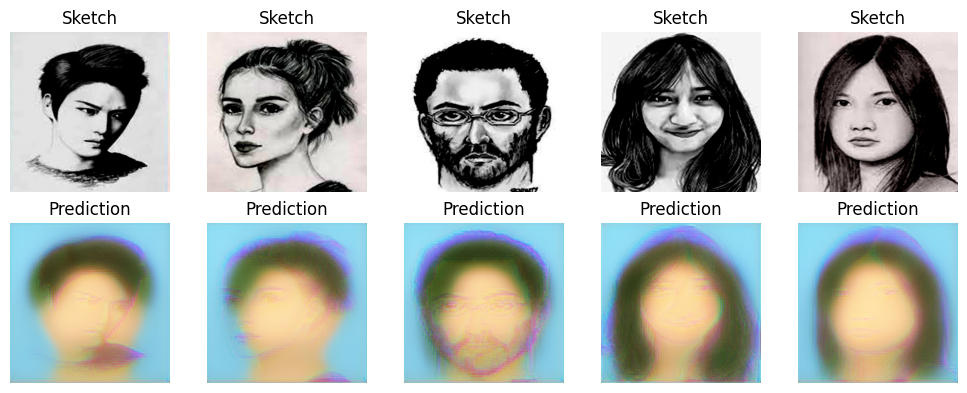

In [24]:
sketch_folder = '/content/testSet'
sketches = load_sketches(sketch_folder)
predictions = generate_predictions(g_model, sketches)
plot_sketches_and_predictions(sketches, predictions)


In [25]:
from skimage.metrics import structural_similarity
import numpy as np
import natsort
import os
import cv2

def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

def load_images(list_path):
    img_list = list()
    for filename in list_path:
        pixels = cv2.imread(filename)
        img_list.append(pixels)
    return np.asarray(img_list)
def compute_l2(imgs1, imgs2):
    l2_scores = []
    for i in range(len(imgs1)):
        score = (np.square(imgs1[i] - imgs2[i])).mean()
        l2_scores.append(score)
    return np.mean(l2_scores)

def compute_ssim(imgs1, imgs2):
    ssim_scores = []
    for i in range(len(imgs1)):
        grayA = cv2.cvtColor(imgs1[i], cv2.COLOR_BGR2GRAY)
        grayB = cv2.cvtColor(imgs2[i], cv2.COLOR_BGR2GRAY)
        (score, diff) = structural_similarity(grayA, grayB, full=True)
        ssim_scores.append(score)
    return np.mean(score)

In [26]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.models import load_model
import numpy as np
import natsort
import cv2
import os


def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)


def load_images(list_path, size=(256, 256)):
    img_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in list_path:
        # load and resize the image
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

def pred_images(g_model, target_dir, filenames, batch_size=128):
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)

    imgs = load_images(filenames)
    g_img = g_model.predict(imgs)
    g_img = g_img * 127.5 + 127.5
    for j, _img in enumerate(g_img):
        cv2.imwrite(target_dir + "/" + os.path.basename(filenames[j]), cv2.resize(cv2.cvtColor(_img.astype('uint8'), cv2.COLOR_RGB2BGR), (200, 250)))
    print("Image has been successfully saved in \"" + target_dir + "\" folder")


filenames = load_filename('/content/testSet/')
g_model = load_model('/content/g_model.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

pred_images(g_model, "/content/predictions/", filenames)

1/1 [==============================] - 1s 648ms/step
Image has been successfully saved in "/content/predictions/" folder


In [27]:
imgs1 = load_images(load_filename("/content/testSet/"))
imgs2 = load_images(load_filename("/content/predictions/"))

l2 = compute_l2(imgs1, imgs2)
ssim = compute_ssim(imgs1, imgs2)

print("Pixel loss weight : 1 - Contextual loss weight : 0 => L2-norm: " + str(l2) + " :: SSIM: " + str(ssim))


Pixel loss weight : 1 - Contextual loss weight : 0 => L2-norm: 0.26920488 :: SSIM: 0.344415246579187
